In [1]:
### ValDXer testing
import os
os.environ['HDXER_PATH'] = '/home/alexi/Documents/HDXer'


In [2]:
# from autonotebook import tqdm as notebook_tqdm

from ValDX.ValidationDX import ValDXer
from ValDX.VDX_Settings import Settings
import pandas as pd
import MDAnalysis as mda


settings = Settings()
settings.replicates = 3
settings.gamma_range = (1,8)
settings.train_frac = 0.5
settings.times = [0.0, 0.5, 5.0]
settings.RW_exponent = [0]
settings.HDXer_stride = 1 # this must be smaller than the size of trajectory
settings.RW_do_reweighting = True
settings.RW_do_params = False
settings.save_figs = False # This is not working in jupyter for some reason
settings.stride = 100
reps = 8

expt_dir = "/home/alexi/Documents/ValDX/raw_data/HOIP/dab3"

HOIP_dir = "/home/alexi/Documents/xMD-HOIP/data/MD/6SC6/APO_dab3"




reps_list = [os.path.join(HOIP_dir, f"R_{i}") for i in range(1, reps+1)]

print(reps_list)


traj_names = ["APO_dab3_6SC6_7-nojump.xtc"]

reordered_traj_names = ["APO_dab3_6SC6_7-nojump_reordered.xtc"]

sim_name = "HOIP_dab3_APO"
top_name = "APO_dab3_6SC6_7-nojump.pdb"
reordered_top_name = "APO_dab3_6SC6_7-nojump_reordered.pdb"

top_path = os.path.join(HOIP_dir, top_name)





import pickle

expt_name = 'Experimental'
test_name = "HOIPdab3"


/home/alexi/Documents/ValDX
['/home/alexi/Documents/xMD-HOIP/data/MD/6SC6/APO_dab3/R_1', '/home/alexi/Documents/xMD-HOIP/data/MD/6SC6/APO_dab3/R_2', '/home/alexi/Documents/xMD-HOIP/data/MD/6SC6/APO_dab3/R_3', '/home/alexi/Documents/xMD-HOIP/data/MD/6SC6/APO_dab3/R_4', '/home/alexi/Documents/xMD-HOIP/data/MD/6SC6/APO_dab3/R_5', '/home/alexi/Documents/xMD-HOIP/data/MD/6SC6/APO_dab3/R_6', '/home/alexi/Documents/xMD-HOIP/data/MD/6SC6/APO_dab3/R_7', '/home/alexi/Documents/xMD-HOIP/data/MD/6SC6/APO_dab3/R_8']


In [3]:
import os
print(os.getenv('HDXER_PATH'))


/home/alexi/Documents/HDXer


In [4]:
print(os.environ["HDXER_PATH"])
print(__name__)

/home/alexi/Documents/HDXer
__main__


In [5]:
def preprocess_main_HDX():

    raw_csv = os.path.join("raw_data", "HOIP","dab3","dab3_3_excel.csv")

    raw_df = pd.read_csv(raw_csv)
    # remove multilevel columns
    # print(raw_df.head())

    # select state dab3
    dab3_df = raw_df[raw_df['State'] == 'dAb3_3']


    # add 697 to Start and End  
    dab3_df['Start'] = dab3_df['Start'] 
    dab3_df['End'] = dab3_df['End']

    # add UptakeFraction column
    dab3_df['UptakeFraction'] = dab3_df['Uptake'] / dab3_df['MaxUptake']
    dab3_df.tail()

    columns_to_drop = ["Protein", "Sequence", "Fragment", "Modification", "State", "MaxUptake", "Uptake", "MHP", "Center", "Center SD", "Uptake", "Uptake SD", "RT", "RT SD"]
    dab3_df = dab3_df.drop(columns_to_drop, axis=1)
    dab3_df.head()
    dab3_df= dab3_df.drop(columns=['Unnamed: 1','Unnamed: 2'])
    dab3_df.head()


    # pivot exposure and uptake fraction
    dab3_df = dab3_df.groupby(['Start', 'End', 'Exposure'])['UptakeFraction'].mean().reset_index()

    dab3_df.head()


    # remove End > 1072
    dab3_df = dab3_df.loc[dab3_df['End'] <= 1072-697]
    dab3_df.head()

    dab3_df = dab3_df.pivot(index=['Start','End'], columns='Exposure', values='UptakeFraction')



    # print entire dataframe
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    print(dab3_df)

    # fill in missing

    dab3_df.reset_index(inplace=True)

    # Forward fill the 'Start' column
    dab3_df['Start'] = dab3_df['Start'].ffill()

    # Set 'Start' and 'End' back as the index if needed
    dab3_df.set_index(['Start', 'End'], inplace=True)

    # save with space delimiter
    # round to 5 dp

    dab3_df = dab3_df.round(5)
    dab3_df.to_csv(os.path.join("raw_data", "HOIP", 'HOIP_dab3_dfs.csv'), sep=' ')





    dab3_df.to_csv(os.path.join("raw_data", "HOIP", "dab3.csv"), index=False)

    # select only Start and End
    dab3_df.reset_index(inplace=True)

    dab3_segs = dab3_df[['Start', 'End']]
    # dab3_segs.drop(columns=["Exposure"])

    dab3_segs.head()


    os.listdir(expt_dir)

    segs_name = "HOIP_dab3_segs.txt"
    segs_path = os.path.join(expt_dir, segs_name)

    hdx_name = "HOIP_dab3_dfs.dat"
    hdx_path = os.path.join(expt_dir, hdx_name)
    print(hdx_path)

    rates_name = "out__train_HOIPdab3_1Intrinsic_rates.dat" #need to correct this
    rates_path =os.path.join(expt_dir, rates_name)


    segs = [(1, 7),
    (6, 18),
    (6, 21),
    (6, 25),
    (7, 18),
    (7, 21),
    (7, 25),
    (8, 18),
    (8, 20),
    (8, 21),
    (8, 24),
    (11, 18),
    (11, 20),
    (11, 21),
    (11, 23),
    (11, 25),
    (19, 25),
    (26, 32),
    (26, 33),
    (27, 33),
    (33, 40),
    (34, 40),
    (34, 41),
    (41, 48),
    (41, 49),
    (41, 51),
    (42, 49),
    (42, 51),
    (42, 65),
    (49, 61),
    (49, 65),
    (50, 65),
    (52, 61),
    (52, 65),
    (74, 84),
    (76, 84),
    (77, 84),
    (77, 85),
    (77, 87),
    (77, 88),
    (77, 97),
    (85, 97),
    (86, 97),
    (88, 97),
    (89, 97),
    (98, 104),
    (98, 106),
    (98, 108),
    (113, 120),
    (114, 120),
    (117, 131),
    (121, 131),
    (121, 132),
    (132, 149),
    (132, 150),
    (132, 153),
    (150, 169),
    (151, 162),
    (151, 167),
    (151, 169),
    (151, 170),
    (154, 169),
    (155, 169),
    (169, 183),
    (170, 183),
    (170, 185),
    (170, 186),
    (171, 183),
    (171, 186),
    (184, 195),
    (184, 208),
    (187, 195),
    (187, 208),
    (187, 209),
    (188, 208),
    (194, 208),
    (196, 208),
    (213, 223),
    (224, 238),
    (224, 239),
    (247, 257),
    (247, 259),
    (247, 260),
    (248, 257),
    (248, 259),
    (248, 260),
    (250, 257),
    (250, 260),
    (253, 260),
    (261, 275),
    (261, 276),
    (261, 278),
    (261, 281),
    (305, 313),
    (305, 315),
    (308, 315),
    (314, 327),
    (316, 327),
    (317, 327),
    (333, 356),
    (334, 356),
    (334, 357),
    (336, 356),
    (336, 357),
    (336, 360),
    (338, 360),
    (339, 360),
    (342, 360)]


    # save as tabbed txt file between each column
    with open(segs_path, 'w') as f:
        for seg in segs:
            f.write("%s\t%s\n" % seg)

    return segs_path, hdx_path, rates_path






In [6]:
def preprocess_main_MD():

    # test reordering 
    # HOIP Chain B resi 697-1072
    # dab3 Chain A C resi 1-120

    top_test = mda.Universe(top_path)
    print(top_test.atoms)

    HOIP_selection = "protein and segid B and resid 697:1072"
    dab3_selection1 = "protein and segid A and resid 1:120"
    dab3_selection2 = "protein and segid C and resid 1:120"

    HOIP = top_test.select_atoms(HOIP_selection)
    # set to Chain A
    # for atom in HOIP:
    #     atom.segment.segid = "A"
        # set chain to A
    dab3_1 = top_test.select_atoms(dab3_selection1)
    # for atom in dab3_1:
    #     atom.segment.segid = "B"
    dab3_2 = top_test.select_atoms(dab3_selection2)
    # for atom in dab3_2:
    #     atom.segment.segid = "C"

    new_order = HOIP + dab3_1 + dab3_2

    print(new_order)

    new_order_universe = mda.Merge(new_order)
    # # renumber residues
    # for idx, res in enumerate(new_order_universe.residues):
    #     res.resid = idx + 1

    print(new_order_universe.atoms)



    # save pdb
    reordered_top_path = os.path.join(HOIP_dir, reordered_top_name)
    new_order_universe.atoms.write(reordered_top_path)


    # re number residues with pdb-tools
    renumbered_path = os.path.join(HOIP_dir, "renumbered.pdb")
    !pdb_reres -1 {reordered_top_path} > {renumbered_path}


    # read in reordered pdb as text
    with open(reordered_top_path, 'r') as f:
        reordered_pdb = f.readlines()

        new_lines = []
        for line in reordered_pdb:
            # print(line)
            split = line.split()
            if "ATOM" == split[0]:
                print(line)
                print(line[21])
                print(line[72])
                # replace index 21 with 72
                line = line[:21] + line[72] + line[22:]
                # break

            new_lines.append(line)

    # with open(reordered_top_path, 'w') as f:
    #     f.writelines(new_lines)
            
        
    #traj_paths is a list of every combination of rep_paths and traj_names

    traj_paths = []
    for rep_path in reps_list:
        for traj_name in traj_names:
            path = os.path.join(rep_path, traj_name)
            print(path)
            traj_paths.append(path)

    # print(top_path)

    # test reordering 
    # HOIP Chain B resi 697-1072
    # dab3 Chain A C resi 1-120

    top_test = mda.Universe(top_path, traj_paths)
    print(len(top_test.trajectory))
    print(top_test.atoms)

    HOIP_selection = "protein and segid B and resid 697:1072"
    dab3_selection1 = "protein and segid A and resid 1:120"
    dab3_selection2 = "protein and segid C and resid 1:120"

    HOIP = top_test.select_atoms(HOIP_selection)
    # set to Chain A
    # for atom in HOIP:
    #     atom.segment.segid = "A"
        # set chain to A
    dab3_1 = top_test.select_atoms(dab3_selection1)
    # for atom in dab3_1:
    #     atom.segment.segid = "B"
    dab3_2 = top_test.select_atoms(dab3_selection2)
    # for atom in dab3_2:
    #     atom.segment.segid = "C"

    new_order = HOIP + dab3_1 + dab3_2

    print(new_order)

    new_order_universe = mda.Merge(new_order)
    print(len(new_order_universe.trajectory))

    # Renumber residues if needed
    # new_resid = 1
    # for residue in new_order_universe.residues:
    #     residue.resid = new_resid
    #     new_resid += 1

    print(new_order_universe.atoms)
    # new_order_universe.atoms.write("test.pdb")

    # Prepare to write the new trajectory
    new_traj_path = os.path.join(HOIP_dir, reordered_traj_names[0])
    with mda.Writer(new_traj_path, new_order_universe.atoms.n_atoms) as W:
        for ts in top_test.trajectory[::settings.stride]:
            # Update positions of the new universe to match the current timestep
            new_order_universe.atoms.positions = top_test.atoms.positions
            # Write the timestep to the new trajectory
            W.write(new_order_universe)
            # W.write(new_order_universe)
            # break



    return new_traj_path, renumbered_path


In [7]:

def run_split_test(split_mode, name, system):

    settings.split_mode = split_mode
    settings.name = "_".join([name, system])

    VDX = ValDXer(settings)


    VDX.load_HDX_data(HDX_path=hdx_path, SEG_path=segs_path, calc_name=expt_name)
    VDX.load_intrinsic_rates(path=rates_path, calc_name=expt_name)

    VDX.load_structures(top_path=renumbered_path, traj_paths=[new_traj_path], calc_name=test_name)
    # VDX.load_structures(top_path=top_path, traj_paths=traj_paths, calc_name=test_name)

    run_outputs = VDX.run_VDX(calc_name=test_name, expt_name=expt_name)
    analysis_dump, df, name = VDX.dump_analysis()
    save_path = VDX.save_experiment()

    return run_outputs, analysis_dump, df, name, save_path

Exposure   0.0       0.5       5.0
Start End                         
1     7    0.0  0.466735  0.435965
6     18   0.0  0.329021  0.417331
      21   0.0  0.437678  0.514648
      25   0.0  0.494072  0.550188
7     18   0.0  0.409742  0.499738
      21   0.0  0.465488  0.532689
      25   0.0  0.518648  0.575634
8     18   0.0  0.428948  0.505906
      20   0.0  0.487081  0.544802
      21   0.0  0.490184  0.554119
      24   0.0  0.522236  0.584780
11    18   0.0  0.490079  0.531893
      20   0.0  0.543597  0.572614
      21   0.0  0.548075  0.583051
      23   0.0  0.603121  0.626074
      25   0.0  0.575935  0.598220
19    25   0.0  0.560898  0.587244
26    32   0.0  0.162769  0.272038
      33   0.0  0.163224  0.282758
27    33   0.0  0.159595  0.267070
33    40   0.0  0.309840  0.407468
34    40   0.0  0.325881  0.412225
      41   0.0  0.317411  0.423762
41    48   0.0  0.381343  0.389136
      49   0.0  0.356548  0.373868
      51   0.0  0.351628  0.404541
42    49   0.0  0.29

/home/alexi/miniconda3/envs/HDXER_CUPY2/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/home/alexi/miniconda3/envs/HDXER_CUPY2/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


ATOM      1  N   GLN B 697      59.300  78.280  23.980  1.00  0.00      B    N  

B
B
ATOM      2  H1  GLN B 697      60.100  78.740  23.560  1.00  0.00      B    H  

B
B
ATOM      3  H2  GLN B 697      58.670  77.870  23.310  1.00  0.00      B    H  

B
B
ATOM      4  H3  GLN B 697      58.680  78.890  24.480  1.00  0.00      B    H  

B
B
ATOM      5  CA  GLN B 697      59.900  77.200  24.830  1.00  0.00      B    C  

B
B
ATOM      6  HA  GLN B 697      60.590  77.700  25.500  1.00  0.00      B    H  

B
B
ATOM      7  CB  GLN B 697      58.780  76.400  25.660  1.00  0.00      B    C  

B
B
ATOM      8  HB1 GLN B 697      59.220  75.550  26.170  1.00  0.00      B    H  

B
B
ATOM      9  HB2 GLN B 697      58.140  76.010  24.870  1.00  0.00      B    H  

B
B
ATOM     10  CG  GLN B 697      57.920  77.310  26.580  1.00  0.00      B    C  

B
B
ATOM     11  HG1 GLN B 697      57.320  77.970  25.960  1.00  0.00      B    H  

B
B
ATOM     12  HG2 GLN B 697      58.500  78.000  27.180

/home/alexi/miniconda3/envs/HDXER_CUPY2/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"
/home/alexi/miniconda3/envs/HDXER_CUPY2/lib/python3.10/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


Path to 'HDXER_ENV' environment: /home/alexi/miniconda3/envs/HDXER_ENV
python /home/alexi/Documents/HDXer/HDXer/calc_hdx.py -t /home/alexi/Documents/xMD-HOIP/data/MD/6SC6/APO_dab3/APO_dab3_6SC6_7-nojump_reordered.xtc -p /home/alexi/Documents/xMD-HOIP/data/MD/6SC6/APO_dab3/renumbered.pdb -m BestVendruscolo -log /home/alexi/Documents/ValDX/data/random_HOIPdab3_test9/train_HOIPdab3_1/calc_hdx_train_HOIPdab3_1.log -out /home/alexi/Documents/ValDX/data/random_HOIPdab3_test9/train_HOIPdab3_1/out__train_HOIPdab3_1 -seg /home/alexi/Documents/ValDX/data/random_HOIPdab3_test9/train_HOIPdab3_1/train_residue_segs__HOIPdab3_.txt -mopt "{ 'save_detailed' : True }" --times 0.0 0.5 5.0 -str 1
Path to 'HDXER_ENV' environment: /home/alexi/miniconda3/envs/HDXER_ENV


/home/alexi/miniconda3/envs/HDXER_CUPY2/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
/home/alexi/Documents/HDXer/HDXer/dfpred.py:505: RuntimeWarning: divide by zero encountered in log
  logerr = logf + np.log(err) + np.log(time) # sd(e^Aa) = f * sd(A) * a


Residue predictions complete


/home/alexi/miniconda3/envs/HDXER_CUPY2/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/alexi/miniconda3/envs/HDXER_CUPY2/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/alexi/miniconda3/envs/HDXER_CUPY2/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/alexi/miniconda3/envs/HDXER_CUPY2/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Path /home/alexi/Documents/ValDX/data/random_HOIPdab3_test9/train_HOIPdab3_1/out__train_HOIPdab3_1Segment_average_fractions.dat
AVG: ncol = 5, len(names) = 3
Experimental HOIPdab3 True 1
/home/alexi/Documents/ValDX/data/random_HOIPdab3_test9/train_HOIPdab3_1/train_HOIPdab3_1_expt_dfracs.dat
/home/alexi/Documents/ValDX/data/random_HOIPdab3_test9/train_HOIPdab3_1
/home/alexi/Documents/ValDX/data/random_HOIPdab3_test9/train_HOIPdab3_1/out__train_HOIPdab3_1Intrinsic_rates.dat
REWIGHTING train_HOIPdab3_1 with Exponent: 0
[{'do_reweight': True, 'do_params': False, 'stepfactor': 0.001, 'basegamma': 1, 'predictHDX_dir': ['/home/alexi/Documents/ValDX/data/random_HOIPdab3_test9/train_HOIPdab3_1'], 'kint_file': '/home/alexi/Documents/ValDX/data/random_HOIPdab3_test9/train_HOIPdab3_1/out__train_HOIPdab3_1Intrinsic_rates.dat', 'exp_file': '/home/alexi/Documents/ValDX/data/random_HOIPdab3_test9/train_HOIPdab3_1/train_HOIPdab3_1_expt_dfracs.dat', 'times': [0.0, 0.5, 5.0], 'restart_interval': 100, 'ou

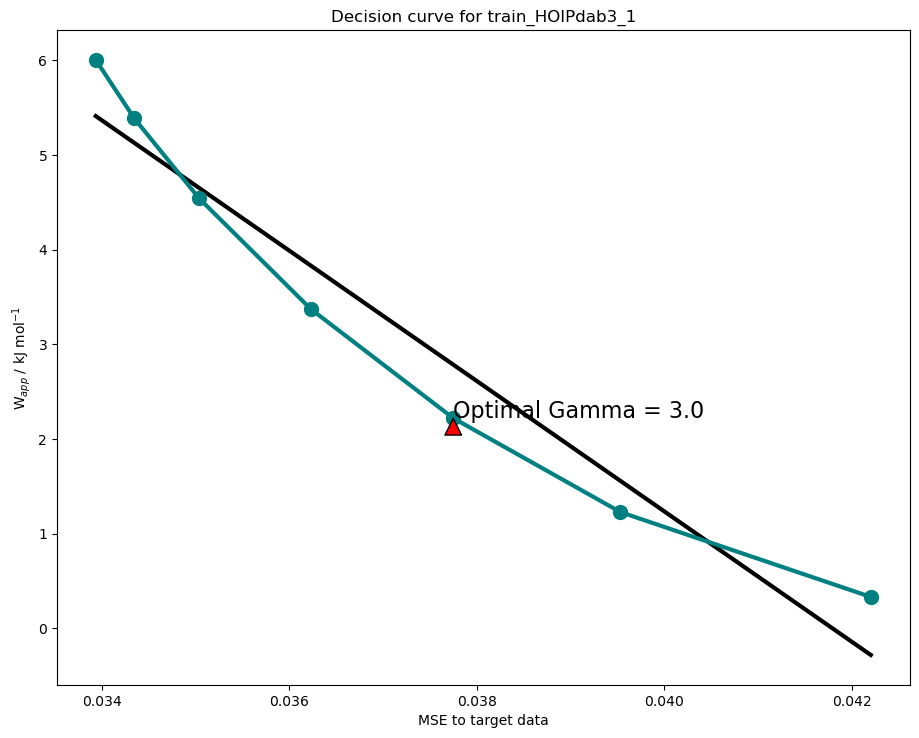

Optimal gamma for train_HOIPdab3_1 is 3.0x10^0
/home/alexi/Documents/ValDX/data/random_HOIPdab3_test9/train_HOIPdab3_1/reweighting_gamma_3x10^0final_segment_fractions.dat
Path /home/alexi/Documents/ValDX/data/random_HOIPdab3_test9/train_HOIPdab3_1/reweighting_gamma_3x10^0final_segment_fractions.dat
RW: ncol = 3, len(names) = 3
(54, 4)
   0.0      0.5      5.0  peptide
0  0.0  0.28097  0.44594        0
1  0.0  0.23995  0.47441        1
2  0.0  0.25902  0.60209        2
3  0.0  0.48172  0.70731        3
4  0.0  0.54110  0.74528        4
    0.0      0.5      5.0  peptide
0   0.0  0.28097  0.44594        0
1   0.0  0.23995  0.47441        1
2   0.0  0.25902  0.60209        2
3   0.0  0.48172  0.70731        3
4   0.0  0.54110  0.74528        4
5   0.0  0.19496  0.36896        5
6   0.0  0.22163  0.35342        6
7   0.0  0.05116  0.31080        7
8   0.0  0.43755  0.72650        8
9   0.0  0.36943  0.85426        9
10  0.0  0.53223  0.73316       10
11  0.0  0.35882  0.67813       11
12  

/home/alexi/miniconda3/envs/HDXER_CUPY2/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


In [8]:

segs_path, hdx_path, rates_path = preprocess_main_HDX()
new_traj_path, renumbered_path = preprocess_main_MD()

splits = ['r', 's', 'R']
split_names = ['random', 'sequential', 'redundancy']
system = 'HOIPdab3_test'

raw_run_outputs = {}
analysis_dumps = {}
analysis_df = pd.DataFrame()
names = []
save_paths = []


for split, split_name in zip(splits, split_names):
    run_outputs, analysis_dump, df, name, save_path = run_split_test(split, split_name, system)
    raw_run_outputs[name] = run_outputs
    analysis_dumps[name] = analysis_dump[name]
    analysis_df = pd.concat([analysis_df, df])
    names.append(name)
    save_paths.append(save_path)



/home/alexi/miniconda3/envs/HDXER_CUPY2/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/alexi/miniconda3/envs/HDXER_CUPY2/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


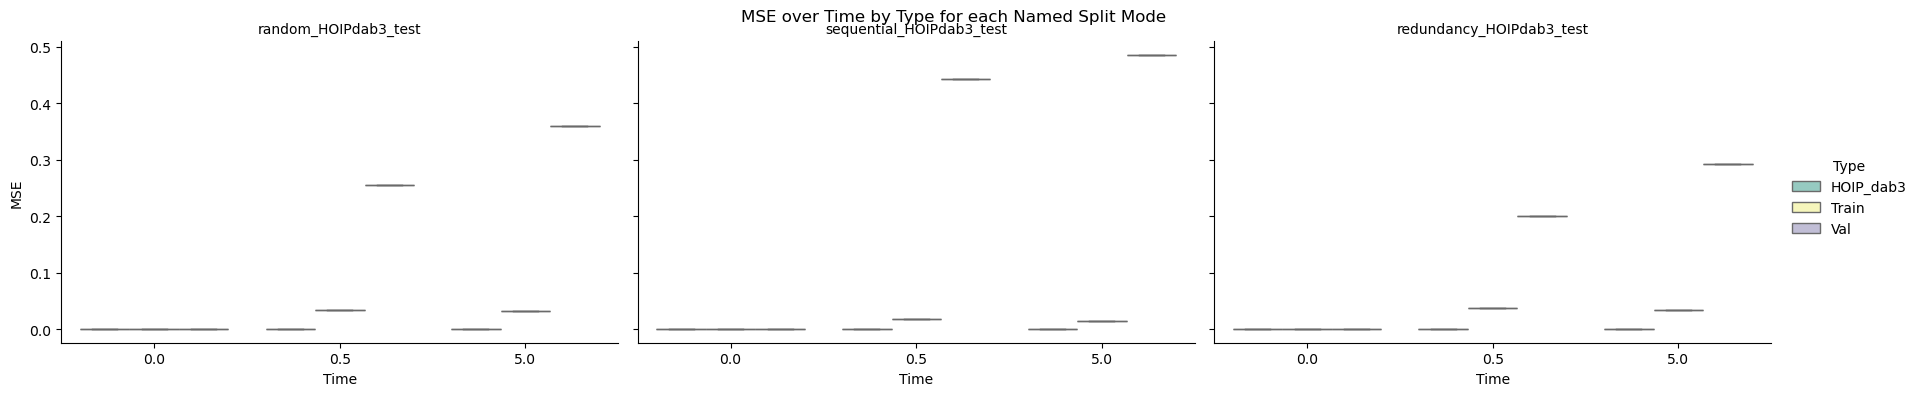

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df
# Replace 'your_dataframe' with your actual DataFrame variable
df = analysis_df

# Create a FacetGrid, using 'name' for each subplot
g = sns.FacetGrid(df, col="name", col_wrap=3, height=4, aspect=1.5)
g.fig.suptitle('MSE over Time by Type for each Named Split Mode')

# Create boxplots
g = g.map(sns.boxplot, "time", "mse", "Type", palette="Set3")

# Adding some additional options for better visualization
g.add_legend(title='Type')
g.set_axis_labels("Time", "MSE")
g.set_titles("{col_name}")

# Adjust the arrangement of the plots
plt.subplots_adjust(top=0.9)

# Show plot
plt.show()


/home/alexi/miniconda3/envs/HDXER_CUPY2/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/alexi/miniconda3/envs/HDXER_CUPY2/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


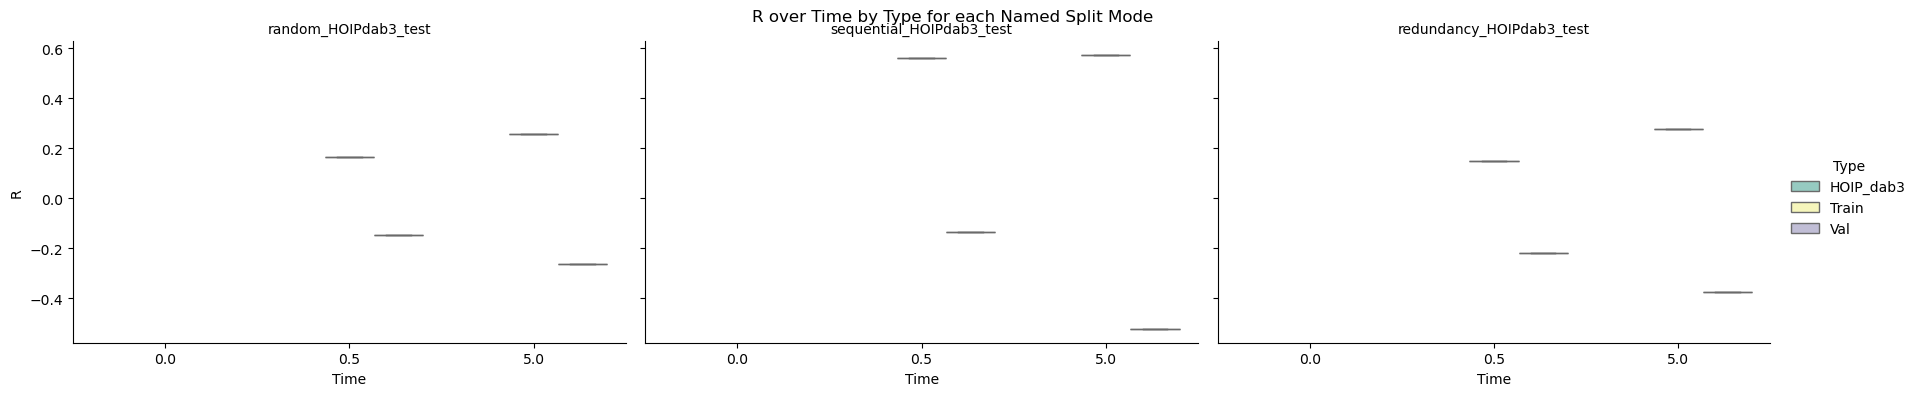

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df
# Replace 'your_dataframe' with your actual DataFrame variable
df = analysis_df

# Create a FacetGrid, using 'name' for each subplot
g = sns.FacetGrid(df, col="name", col_wrap=3, height=4, aspect=1.5)
g.fig.suptitle('R over Time by Type for each Named Split Mode')

# Create boxplots
g = g.map(sns.boxplot, "time", "R", "Type", palette="Set3")

# Adding some additional options for better visualization
g.add_legend(title='Type')
g.set_axis_labels("Time", "R")
g.set_titles("{col_name}")

# Adjust the arrangement of the plots
plt.subplots_adjust(top=0.9)

# Show plot
plt.show()
